# Lecture 11 - Dimension Reduction and Clustering

{contents}
:local:
:depth: 1

## Learning goals

- Understand **unsupervised learning** vs **supervised learning** in chemistry.
- Explain the intuition and math of **PCA** and read **loadings**, **scores**, and **explained variance**.
- Use **t-SNE** and **UMAP** to embed high dimensional chemical features to 2D for visualization.
- Perform **K-means** clustering, choose **K** using elbow and silhouette, and interpret clusters.

---

## 1. Setup and data

We will reuse the C–H oxidation dataset and compute a small set of descriptors.

In [1]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances

try:
  import umap.umap_ as umap
except:
  %pip install umap-learn
  import umap.umap_ as umap

# Utils
import warnings
warnings.filterwarnings("ignore")


try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
    RD = True
except Exception:
    try:
      %pip install rdkit
      from rdkit import Chem
      from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
      RD = True
    except:
      RD = False
      Chem = None

In [2]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)
df_raw.head(3)

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10"
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10"


We compute four quick descriptors for everyone. If RDKit is available, we will also compute a binary Morgan fingerprint.

In [3]:
def calc_descriptors(smiles: str):
    if not RD or smiles is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    return pd.Series({
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "NumRings": rdMolDescriptors.CalcNumRings(m),
    })

desc = df_raw["SMILES"].apply(calc_descriptors)
df = pd.concat([df_raw, desc], axis=1)

print("Rows x Cols:", df.shape)
df[["Compound Name","SMILES","MolWt","LogP","TPSA","NumRings","Toxicity"]].head()

Rows x Cols: (575, 13)


,Compound Name,SMILES,MolWt,LogP,TPSA,NumRings,Toxicity
0,"3,4-dihydro-1H-isochromene",c1ccc2c(c1)CCOC2,134.178,1.7593,9.23,2.0,non_toxic
1,9H-fluorene,c1ccc2c(c1)Cc1ccccc1-2,166.223,3.2578,0.00,3.0,toxic
2,"1,2,3,4-tetrahydronaphthalene",c1ccc2c(c1)CCCC2,132.206,2.5654,0.00,2.0,toxic
3,ethylbenzene,CCc1ccccc1,106.168,2.2490,0.00,1.0,non_toxic
4,cyclohexene,C1=CCCCC1,82.146,2.1166,0.00,1.0,non_toxic


Now we build a 1024-bit Morgan fingerprint ($r=2$). We keep both a **small descriptor table** and a **high dimensional fingerprint** table.

In [4]:
if RD:
    def morgan_bits(smiles, n_bits=1024, radius=2):
        m = Chem.MolFromSmiles(smiles)
        if m is None:
            return np.zeros(n_bits, dtype=np.int8)
        bv = rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=radius, nBits=n_bits)
        arr = np.zeros((n_bits,), dtype=np.int8)
        _ = Chem.DataStructs.ConvertToNumpyArray(bv, arr)  # fills arr in place
        return arr

    X_fp = np.vstack(df["SMILES"].apply(morgan_bits).to_numpy())
    print("Fingerprint shape:", X_fp.shape)
else:
    X_fp = None
    print("RDKit not available. Fingerprints will be skipped.")

# Small numeric descriptors
X_small = df[["MolWt","LogP","TPSA","NumRings"]].astype(float).to_numpy()
mask_small = np.isfinite(X_small).all(axis=1)
X_small = X_small[mask_small]
labels_all = df.loc[mask_small, "Toxicity"].str.lower().map({"toxic":1, "non_toxic":0})
y_toxic = labels_all.fillna(-1).to_numpy()  # -1 if missing

print("Small descriptor matrix:", X_small.shape, "  Toxicity labels:", np.unique(y_toxic, return_counts=True))

Fingerprint shape: (575, 1024)
Small descriptor matrix: (575, 4)   Toxicity labels: (array([0, 1], dtype=int64), array([101, 474], dtype=int64))


```{admonition} Data choices
- **X_small** uses 4 descriptors. Good for first PCA stories.
- **X_fp** has 1024 bits. Good for t-SNE or UMAP since it is very high dimensional.
```

```{admonition} ⏰ Exercise 1
1. How many rows were dropped because of missing descriptor values? Use `mask_small.sum()` and `len(mask_small)` to compute it.
2. If RDKit is available, check the fraction of 1-bits in the fingerprints for the first 5 molecules.
```

### 1.4 Why two feature tables

We keep both a low dimensional table and a high dimensional table on purpose.

- The 4-descriptor table is easy to standardize and to interpret.
- The 1024-bit fingerprint captures substructure presence or absence and is useful for neighborhood maps.

When you learn a new method, start with the small table. Once the idea feels solid, switch to fingerprints to stress test the method.

### 1.5 Sanity checks on raw data

Before any modeling, confirm shapes, missing values, and duplicates. We will store a few quick counts that we will reuse in later plots.

In [5]:
n_rows = len(df)
n_unique_smiles = df["SMILES"].nunique()
n_missing_smiles = df["SMILES"].isna().sum()
n_missing_tox = df["Toxicity"].isna().sum()
print("Rows:", n_rows)
print("Unique SMILES:", n_unique_smiles)
print("Missing SMILES:", n_missing_smiles)
print("Missing toxicity labels:", n_missing_tox)

Rows: 575
Unique SMILES: 575
Missing SMILES: 0
Missing toxicity labels: 0


Narrative:

- The number of unique SMILES tells us how many unique structures exist in this dataset.
- Missing toxicity does not block unsupervised methods since they do not use labels. We will still color points by the available labels for interpretation.

### 1.6 Fixing a possible RDKit quirk

Some RDKit builds expose `ConvertToNumpyArray` via `rdkit.DataStructs` rather than `Chem.DataStructs`. If your earlier fingerprint cell failed, run this patch cell. It will recompute `X_fp` only when needed.

In [6]:
if RD:
    try:
        _ = Chem.DataStructs
        rdkit_ok = True
    except Exception:
        rdkit_ok = False

    if (X_fp is None) or (not rdkit_ok) or (isinstance(X_fp, str)):
        try:
            from rdkit import DataStructs
            def morgan_bits_safe(smiles, n_bits=1024, radius=2):
                m = Chem.MolFromSmiles(smiles)
                if m is None:
                    return np.zeros(n_bits, dtype=np.int8)
                bv = rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=radius, nBits=n_bits)
                arr = np.zeros((n_bits,), dtype=np.int8)
                DataStructs.ConvertToNumpyArray(bv, arr)
                return arr
            X_fp = np.vstack(df["SMILES"].apply(morgan_bits_safe).to_numpy())
            print("Rebuilt fingerprints with rdkit.DataStructs. Shape:", X_fp.shape)
        except Exception as e:
            print("Could not rebuild fingerprints. Proceed with X_small only.", e)

### 1.7 A first look at Morgan fingerprints

Morgan fingerprints are circular substructure fingerprints. Bit $j$ equals 1 if at least one circular environment of a given radius hashes to that bit. For radius $r=2$, the environment includes neighbors up to two bonds away.

We will compute for the first few molecules:

- the number of set bits,
- the fraction of set bits,
- an index list of which bits are active.

In [7]:
if RD and X_fp is not None:
    active_counts = X_fp[:10].sum(axis=1)
    frac_active = active_counts / X_fp.shape[1]
    print("Active bit counts (first 10):", active_counts.tolist())
    print("Fraction active (first 10):", np.round(frac_active, 4).tolist())

Active bit counts (first 10): [19, 14, 13, 14, 8, 8, 17, 17, 22, 16]
Fraction active (first 10): [0.0186, 0.0137, 0.0127, 0.0137, 0.0078, 0.0078, 0.0166, 0.0166, 0.0215, 0.0156]


Let us also peek at which bit indices are set for the very first molecule. This gives a sense of sparsity.

In [8]:
if RD and X_fp is not None:
    idx0 = np.where(X_fp[0] == 1)[0]
    print("First molecule. Active bit indices:", idx0[:25].tolist(), " ... total =", len(idx0))

First molecule. Active bit indices: [64, 128, 140, 175, 212, 242, 356, 364, 523, 609, 656, 684, 714, 726, 752, 776, 849, 926, 950]  ... total = 19


```{admonition} Tip
Binary fingerprints are sparse. Most bits are zero for any particular molecule. This is why cosine or Jaccard distances often behave better than Euclidean on raw bit vectors.
```

### 1.8 Optional: recover substructures for a few bits

RDKit can report which atom environments triggered a bit via the `bitInfo` dictionary. This gives intuition about what the fingerprint encodes.

In [9]:
if RD:
    from rdkit.Chem import rdMolDescriptors as rdm
    def bit_environment_examples(smiles, n_bits=1024, radius=2, max_show=5):
        m = Chem.MolFromSmiles(smiles)
        if m is None:
            return {}
        bitInfo = {}
        bv = rdm.GetMorganFingerprintAsBitVect(m, radius=radius, nBits=n_bits, bitInfo=bitInfo)
        # bitInfo: {bit_id: [(atom_idx, radius), ...]}
        # Return only a few entries for display
        out = {}
        for k, v in list(bitInfo.items())[:max_show]:
            out[k] = v
        return out

    env = bit_environment_examples(df.loc[0, "SMILES"])
    print("Example bit environments (bit id -> (atom_index, radius)):", env)

Example bit environments (bit id -> (atom_index, radius)): {64: ((1, 1), (0, 1)), 128: ((8, 2),), 140: ((6, 2),), 175: ((1, 2), (0, 2)), 212: ((4, 1), (3, 1))}


Narrative:

- The same bit can be set by multiple distinct environments because of hashing.
- For teaching, pick one molecule and inspect two or three bits with the largest number of occurrences.

```{admonition} ⏰ Mini exercise
Pick a molecule by index. Use the helper above to list a few bit environments. Change the radius to 3 and compare how many environments get recorded.
```

---

## 2. Supervised vs unsupervised

In Lectures 6 to 8 we learned supervised models that map $x \to y$ with labeled targets. Today we switch to **unsupervised learning**.

- **Dimension reduction**: summarize high dimensional $x \in \mathbb{R}^p$ to a few coordinates $z \in \mathbb{R}^k$ with $k \ll p$. You do not use $y$ during the fit.
- **Clustering**: group samples into clusters based on a similarity or distance rule. Again no labels during the fit.

We will color plots using toxicity when available. That is only to **interpret** the embedding or clusters. It is not used in the algorithms.

```{admonition} Key idea
Unsupervised learning looks for structure that is already present in $X$. Labels are for *evaluation* and interpretation only, not for fitting.
```

```{admonition} ⏰ Exercise 2
State whether each task is supervised or unsupervised:

- Predict melting point from descriptors.
- Group molecules by scaffold similarity.
- Map 1024-bit fingerprints to 2D for plotting.
- Predict toxicity from descriptors.
```

### 2.1 What counts as a feature in chemistry

Feature choices will drive everything downstream. You can use:

- Scalar descriptors like MolWt, LogP, TPSA, ring counts.
- Fingerprints like Morgan bits or MACCS keys.
- Learned embeddings from a graph neural network. We will not use those here, but the same methods apply.

If two students use different features, their PCA or UMAP plots will look different. That is expected.

### 2.2 Data leakage in unsupervised settings

Even in unsupervised workflows, leakage can happen. A common mistake is to use the full dataset to standardize, then later split for evaluation. Safer pattern:

1. Split the dataset.
2. Fit the scaler on the training subset.
3. Transform train and test with the fitted scaler.

In [10]:
from sklearn.model_selection import train_test_split
Xs_leak = StandardScaler().fit_transform(X_small)  # risky pattern if you plan to evaluate downstream

Xtr, Xte = train_test_split(X_small, test_size=0.25, random_state=0)
sc = StandardScaler().fit(Xtr)
Xtr_s = sc.transform(Xtr)
Xte_s = sc.transform(Xte)
print("Standardized shapes:", Xtr_s.shape, Xte_s.shape)

Standardized shapes: (431, 4) (144, 4)


Narrative:

- In pure visualization use cases, the risk is smaller since we are not optimizing a predictive model.
- For cluster analysis that will be compared to labels afterward, keep the split discipline.

---

## 3. Standardization and distance

PCA and K-means are sensitive to scale. Always check the mean and standard deviation of features.

In [11]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X_small)

print("Means (should be ~0):", np.round(Xs.mean(axis=0), 3))
print("Stds  (should be ~1):", np.round(Xs.std(axis=0), 3))

Means (should be ~0): [ 0.  0.  0. -0.]
Stds  (should be ~1): [1. 1. 1. 1.]


We also pick a distance. Two common choices:

- **Euclidean** on standardized features.
- **Cosine** which compares angles and ignores magnitude.

Below we compute both between the first 5 rows.

In [12]:
sub = Xs[:5]
D_euc = pairwise_distances(sub, metric="euclidean")
D_cos = pairwise_distances(sub, metric="cosine")

print("Euclidean distances (5x5):\n", np.round(D_euc, 3))
print("\nCosine distances (5x5):\n", np.round(D_cos, 3))

Euclidean distances (5x5):
 [[0.    1.207 0.564 0.856 0.958]
 [1.207 0.    0.876 1.624 1.772]
 [0.564 0.876 0.    0.761 0.91 ]
 [0.856 1.624 0.761 0.    0.271]
 [0.958 1.772 0.91  0.271 0.   ]]

Cosine distances (5x5):
 [[0.    0.372 0.073 0.09  0.075]
 [0.372 0.    0.186 0.444 0.443]
 [0.073 0.186 0.    0.068 0.068]
 [0.09  0.444 0.068 0.    0.004]
 [0.075 0.443 0.068 0.004 0.   ]]


```{admonition} Tip
For sparse fingerprints, cosine distance or Jaccard often makes more sense than raw Euclidean. For dense scaled descriptors, Euclidean is fine.
```

### 3.1 Jaccard and Tanimoto for binary fingerprints

For bit vectors $A$ and $B$:

- Count $a = \|A\|_1$, $b = \|B\|_1$, and $c = A \cdot B$ which is the count of shared 1s.
- **Tanimoto similarity** is $S = \dfrac{c}{a + b - c}$.
- **Jaccard distance** is $1 - S$.

We can implement a tiny helper that computes Tanimoto for a small batch. The code is simple but gives a concrete feel.

In [13]:
def tanimoto_pairwise(Xbin):
    Xbin = Xbin.astype(np.uint8)
    n = Xbin.shape[0]
    out = np.eye(n, dtype=float)
    ones = Xbin.sum(axis=1)
    for i in range(n):
        for j in range(i+1, n):
            c = np.dot(Xbin[i], Xbin[j])
            denom = ones[i] + ones[j] - c
            s = 0.0 if denom == 0 else c / denom
            out[i, j] = s
            out[j, i] = s
    return out

if RD and X_fp is not None:
    S_tan = tanimoto_pairwise(X_fp[:6])
    print("Tanimoto similarity (6x6):\n", np.round(S_tan, 3))

Tanimoto similarity (6x6):
 [[1.    0.32  0.455 0.179 0.08  0.038]
 [0.32  1.    0.421 0.217 0.1   0.048]
 [0.455 0.421 1.    0.227 0.167 0.105]
 [0.179 0.217 0.227 1.    0.048 0.   ]
 [0.08  0.1   0.167 0.048 1.    0.143]
 [0.038 0.048 0.105 0.    0.143 1.   ]]


Narrative:

- If two molecules have no bits set in common, $S=0$.
- If they are identical in bits, $S=1$.
- For Morgan fingerprints, Tanimoto is the default similarity used in many cheminformatics tools.

### 3.2 Robust scaling and outliers

Chemistry features like TPSA or MolWt can have long tails. Robust scaling uses the median and IQR instead of mean and standard deviation.

In [14]:
from sklearn.preprocessing import RobustScaler
Xr = RobustScaler().fit_transform(X_small)
print("Robust-scaled feature medians ~0:", np.round(np.median(Xr, axis=0), 3))

Robust-scaled feature medians ~0: [0. 0. 0. 0.]


When should you use robust scaling:

- Many outliers.
- You care about relative ordering more than exact distances.

### 3.3 Visual check of feature distributions

Small histograms help you decide scaling. We will plot the four descriptors in simple panels.

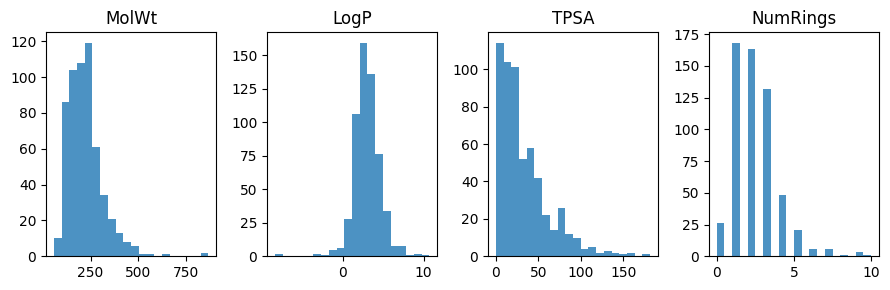

In [15]:
cols = ["MolWt","LogP","TPSA","NumRings"]
plt.figure(figsize=(9,3))
for i, c in enumerate(cols, 1):
    plt.subplot(1,4,i)
    plt.hist(df.loc[mask_small, c], bins=20, alpha=0.8)
    plt.title(c); plt.tight_layout()
plt.show()

Observation:

- Skewed distributions suggest log transforms or robust scaling.
- Counts near zero for NumRings show many monocyclic or bicyclic molecules. That will influence PCA loadings.

---

## 4. PCA by hand: step by step

PCA finds orthogonal directions that capture maximum variance. We implement the steps on the standardized matrix.

Mathematical pieces:

- Centered data $\tilde X$ is already produced by StandardScaler.
- Covariance $S = \frac{1}{n-1}\tilde X^\top \tilde X$.
- Either eigen-decompose $S$, or compute SVD of $\tilde X = U \Sigma V^\top$.
- The top $k$ columns of $V$ are the principal directions. Scores are $Z = \tilde X V_k$.

### 4.1 Centering and covariance

In [16]:
n, p = Xs.shape
Xc = Xs  # already standardized
S = (Xc.T @ Xc) / (n - 1)

print("Xc shape:", Xc.shape)
print("Covariance shape:", S.shape)

Xc shape: (575, 4)
Covariance shape: (4, 4)


### 4.2 SVD and explained variance

In [17]:
U, Sig, VT = np.linalg.svd(Xc, full_matrices=False)  # Xc = U * diag(Sig) * VT
eigvals = (Sig ** 2) / (n - 1)
evr = eigvals / eigvals.sum()

print("Singular values:", np.round(Sig, 3))
print("Explained variance ratio:", np.round(evr, 3))

Singular values: [36.978 26.855 12.106  8.052]
Explained variance ratio: [0.595 0.314 0.064 0.028]


### 4.3 Project to 2D and inspect

Scores shape: (575, 2)
First 3 rows:
 [[-1.224  0.346]
 [-0.258  1.043]
 [-1.08   0.863]]


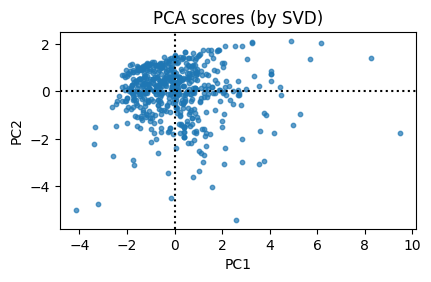

In [18]:
V2 = VT[:2].T             # p x 2
Z2 = Xc @ V2              # n x 2 scores
print("Scores shape:", Z2.shape)
print("First 3 rows:\n", np.round(Z2[:3], 3))

plt.figure(figsize=(4.6,4.2))
plt.scatter(Z2[:,0], Z2[:,1], s=10, alpha=0.7)
plt.axhline(0, ls=":", c="k"); plt.axvline(0, ls=":", c="k")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA scores (by SVD)")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

```{admonition} Loadings
Columns of $V$ are **loadings**. They tell how each original feature contributes to each PC. Large magnitude means strong contribution.
```

```{admonition} ⏰ Exercise 4
Print the 4x2 loading matrix `V2` with 3 decimals. Which descriptor dominates PC1?
```

### 4.4 Reconstructing original features from PCs

Given $Z_k$ and $V_k$, you can reconstruct an approximation of $X$ as $\hat X = Z_k V_k^\top$. Since we standardized, this returns standardized units.

In [19]:
Xhat = Z2 @ V2.T
rmse = np.sqrt(np.mean((Xc - Xhat)**2))
print("RMSE of 2-PC reconstruction in standardized units:", round(rmse, 3))

RMSE of 2-PC reconstruction in standardized units: 0.303


Narrative:

- As $k$ increases, $Xhat$ gets closer to $X$.
- A small $k$ gives a compressed summary useful for visualization and clustering.

### 4.5 Hotelling $T^2$ and Q residuals

Two common PCA diagnostics:

- Hotelling $T^2$ is the squared Mahalanobis distance in score space: $T^2 = \sum_{j=1}^{k}\frac{z_{ij}^2}{\lambda_j}$.
- Q residuals measure leftover variance outside the model: $Q = \lVert x_i - \hat x_i\rVert^2$.

We will compute both for $k=2$ and highlight the top outliers.

In [20]:
lam = eigvals[:2]
T2 = (Z2**2 / lam).sum(axis=1)
Q  = ((Xc - Xhat)**2).sum(axis=1)
print("T2 range:", (float(T2.min()), float(T2.max())))
print("Q  range:", (float(Q.min()), float(Q.max())))

T2 range: (0.0017864424718611982, 40.251470053322144)
Q  range: (0.00014111758268102242, 17.164253116068526)


Plot the Q residuals as a simple stem plot.

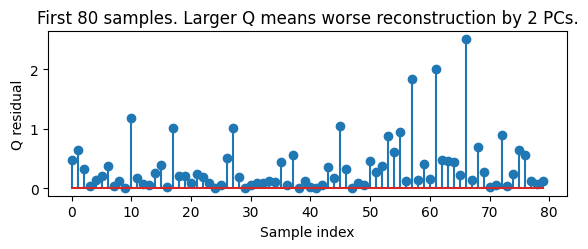

In [21]:
plt.figure(figsize=(6,2.6))
plt.stem(Q[:80], use_line_collection=True)
plt.xlabel("Sample index"); plt.ylabel("Q residual")
plt.title("First 80 samples. Larger Q means worse reconstruction by 2 PCs.")
plt.tight_layout(); plt.show()

### 4.6 Sign indeterminacy and rotation

Loadings have arbitrary sign. If you multiply a loading vector by $-1$, scores flip sign as well, and the model remains the same. Do not interpret signs as absolute truths. Interpret directions relative to each other.

In [22]:
# Demonstrate sign flip
V2_flip = V2.copy()
V2_flip[:,0] *= -1
Z2_flip = Xc @ V2_flip
d = np.allclose(Z2_flip[:,0], -Z2[:,0]) and np.allclose(Z2_flip[:,1], Z2[:,1])
print("Sign flip leaves model equivalent:", d)

Sign flip leaves model equivalent: True


### 4.7 PCA with and without scaling

To see why scaling matters, run PCA without standardizing.

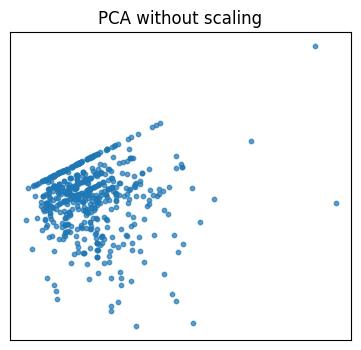

Unscaled EVR: [0.924 0.076]


In [23]:
pca_noscale = PCA(n_components=2).fit(X_small)  # no scaling
Z_ns = pca_noscale.transform(X_small)

plt.figure(figsize=(4.4,4.0))
plt.scatter(Z_ns[:,0], Z_ns[:,1], s=10, alpha=0.7)
plt.title("PCA without scaling")
plt.xticks([]); plt.yticks([])
plt.show()

print("Unscaled EVR:", np.round(pca_noscale.explained_variance_ratio_, 3))

Observation:

- MolWt typically dominates variance if you skip scaling. That can hide patterns from TPSA or LogP.

---

## 5. PCA with scikit-learn and interpretation

Now we use `sklearn.decomposition.PCA` and compare to the by-hand result.

### 5.1 Fit PCA and compare EVR

In [24]:
pca = PCA(n_components=4, random_state=0)
Z = pca.fit_transform(Xs)

print("Explained variance ratio:", np.round(pca.explained_variance_ratio_, 3))
print("Cumulative:", np.round(pca.explained_variance_ratio_.cumsum(), 3))
print("Components shape:", pca.components_.shape)  # 4 x 4 (each row is a PC)

Explained variance ratio: [0.595 0.314 0.064 0.028]
Cumulative: [0.595 0.908 0.972 1.   ]
Components shape: (4, 4)


### 5.2 Scree plot

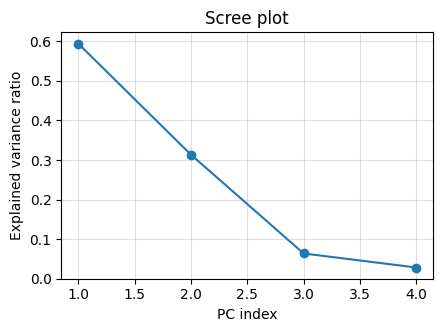

In [25]:
plt.figure(figsize=(4.8,3.2))
plt.plot(np.arange(1, p+1), pca.explained_variance_ratio_, marker="o")
plt.xlabel("PC index"); plt.ylabel("Explained variance ratio")
plt.title("Scree plot")
plt.grid(True, alpha=0.4)
plt.show()

### 5.3 Biplot: scores and loadings

We plot PC1 vs PC2 and overlay loading vectors. For color we use toxicity when known. This color is for **reading** the map only.

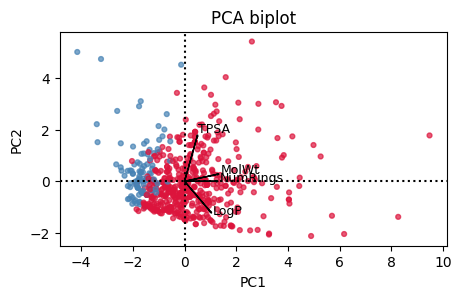

In [26]:
scores = Z[:, :2]
loads = pca.components_[:2, :].T  # shape 4x2
cols = ["MolWt","LogP","TPSA","NumRings"]

plt.figure(figsize=(5,4.6))
c = np.where(y_toxic[:len(scores)]==1, "crimson",
    np.where(y_toxic[:len(scores)]==0, "steelblue", "gray"))
plt.scatter(scores[:,0], scores[:,1], s=12, alpha=0.7, c=c)
plt.axhline(0, ls=":", c="k"); plt.axvline(0, ls=":", c="k")

for i, name in enumerate(cols):
    x, y = loads[i,0]*2.2, loads[i,1]*2.2
    plt.arrow(0, 0, x, y, head_width=0.05, length_includes_head=True)
    plt.text(x*1.05, y*1.05, name, fontsize=9)

plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA biplot")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

```{admonition} Reading a biplot
- Points near each other have similar standardized descriptors.
- A loading arrow points in the direction of increase of that feature.
- The projection of a point onto an arrow relates to that feature value.
```

```{admonition} ⏰ Exercise 5
Set `PCA(n_components=2, whiten=True)` and replot the biplot. How do the axes scale and the scatter change?
```

### 5.4 Which molecules live at extremes of PCs

A simple trick to interpret PCs is to find molecules at the tails of PC1 and PC2. We will print their SMILES and descriptor values.

In [27]:
df_pc = pd.DataFrame(scores, columns=["PC1","PC2"])
df_pc["idx"] = np.arange(len(df_pc))
df_pc["SMILES"] = df.loc[mask_small, "SMILES"].values
df_pc = pd.concat([df_pc, pd.DataFrame(X_small, columns=["MolWt","LogP","TPSA","NumRings"]).reset_index(drop=True)], axis=1)

tails = pd.concat([
    df_pc.nsmallest(3, "PC1"),
    df_pc.nlargest(3, "PC1"),
    df_pc.nsmallest(3, "PC2"),
    df_pc.nlargest(3, "PC2"),
], axis=0)

cols_show = ["idx","SMILES","PC1","PC2","MolWt","LogP","TPSA","NumRings"]
tails[cols_show].round(3)

,idx,SMILES,PC1,PC2,MolWt,LogP,TPSA,NumRings
462,462,[Na+].[O-][Cl+3]([O-])([O-])[O-],-4.152,5.006,122.439,-7.752,92.24,0.0
453,453,O=N[O-].[Na+],-3.397,2.211,68.995,-2.745,52.49,0.0
459,459,CC(C)(C)[O-].[K+],-3.366,1.514,112.213,-2.851,23.06,0.0
61,61,CC12CCC3C(CC=C4CC(OC5OC(COC(=O)c6ccccc6)C(OC(=...,9.482,1.775,867.004,9.162,140.73,9.0
338,338,c1ccc(-n2c(-c3cc(-c4nc5ccccc5n4-c4ccccc4)cc(-c...,8.269,-1.376,654.777,10.704,53.46,10.0
340,340,Ic1ccc(C(=C(c2ccc(I)cc2)c2ccc(I)cc2)c2ccc(I)cc...,6.177,-2.039,836.030,9.112,0.00,4.0
290,290,c1ccc2c(c1)=c1ccc3c4ccc5c6c(ccc(c7ccc=2c1c37)c...,4.898,-2.117,400.480,7.512,0.00,9.0
532,532,c1cc2ccc3ccc4ccc5ccc6ccc1c1c2c3c4c5c61,3.267,-2.062,300.360,6.919,0.00,7.0
340,340,Ic1ccc(C(=C(c2ccc(I)cc2)c2ccc(I)cc2)c2ccc(I)cc...,6.177,-2.039,836.030,9.112,0.00,4.0
510,510,C=C1c2cccc(O)c2C(O)=C2C(=O)C3(O)C(O)=C(C(N)=O)...,2.606,5.410,478.885,-0.173,181.62,4.0


Narrative:

- Extreme PC1 to the right will have larger values on features with positive loadings on PC1.
- Extreme PC1 to the left will have larger values on features with negative loadings on PC1.

### 5.5 Annotate a few molecules on the PC1 vs PC2 scatter

We randomly pick a few molecules and label them by index to show how you can connect points to SMILES.

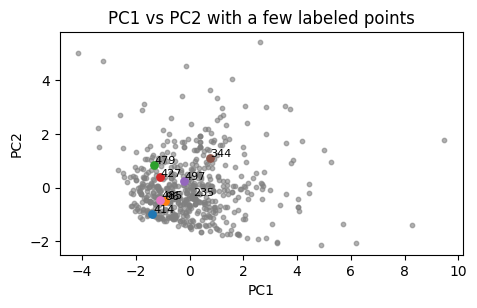

Labeled indices and SMILES:


,idx,SMILES
96,96,Cc1cnc2ccccc2c1
235,235,CCc1ccc(COC(=O)c2ccccc2)cc1
344,344,O=c1c(-c2ccc(O)cc2)coc2cc(O)ccc12
414,414,CC(C)Cc1ccccc1
427,427,CCOc1ccc(C(=O)OC)cc1
479,479,COC(=O)c1sccc1O
485,485,CC(C)(C)c1ccc(C=O)cc1
497,497,N#Cc1ccc(C(=O)c2ccccc2)cc1


In [28]:
np.random.seed(0)
idx_pick = np.random.choice(len(scores), size=min(8, len(scores)), replace=False)
plt.figure(figsize=(5.2,4.8))
plt.scatter(scores[:,0], scores[:,1], s=10, alpha=0.6, color="gray")
for i in idx_pick:
    plt.scatter(scores[i,0], scores[i,1], s=28)
    plt.text(scores[i,0]+0.03, scores[i,1]+0.03, str(int(i)), fontsize=8)
plt.title("PC1 vs PC2 with a few labeled points")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

print("Labeled indices and SMILES:")
display(df_pc.loc[idx_pick, ["idx","SMILES"]].sort_values("idx"))

### 5.6 A loadings heatmap for all four descriptors

For small $p$ a heatmap is readable and builds intuition for how loadings spread across components.

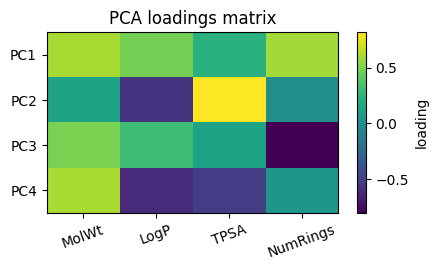

In [29]:
plt.figure(figsize=(4.6,2.8))
plt.imshow(pca.components_, aspect="auto", interpolation="nearest")
plt.colorbar(label="loading")
plt.yticks(range(4), [f"PC{i+1}" for i in range(4)])
plt.xticks(range(4), ["MolWt","LogP","TPSA","NumRings"], rotation=20)
plt.title("PCA loadings matrix")
plt.tight_layout(); plt.show()

### 5.7 Case study: MOF screening dataset

We now add a second dataset for practice. It describes a grid of synthetic experiments for metal organic framework formation. Columns:

- `linker_smiles` for the organic linker,
- `temperature` in °C,
- `time_h` in hours,
- `concentration_M` in molarity,
- `solvent_DMF` as a binary flag (0 for water, 1 for DMF),
- `yield` as the output variable.

We will read it and compute descriptor columns for each unique linker. Then we will merge descriptors back to the experiment table.

In [30]:
url_mof = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/mof_yield_dataset.csv"
mof = pd.read_csv(url_mof)
print("MOF rows x cols:", mof.shape)
mof.head(3)

HTTPError: HTTP Error 404: Not Found

Compute descriptors for the 10 linkers and merge.

In [ ]:
if RD:
    linkers = pd.DataFrame({"linker_smiles": sorted(mof["linker_smiles"].unique())})
    linkers_desc = linkers["linker_smiles"].apply(calc_descriptors)
    linkers_full = pd.concat([linkers, linkers_desc], axis=1)
    mof_full = mof.merge(linkers_full, on="linker_smiles", how="left")
else:
    mof_full = mof.copy()
    for c in ["MolWt","LogP","TPSA","NumRings"]:
        mof_full[c] = np.nan

mof_full.describe(include="all").T.head(12)

### 5.8 Explore MOF inputs and outputs

We plot histograms for the continuous inputs and the yield distribution.

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(9,5))
ax = axes.ravel()
cols_cont = ["temperature","time_h","concentration_M","yield"]
labels = ["Temperature (°C)","Time (h)","Concentration (M)","Yield (%)"]
for i, (c, lab) in enumerate(zip(cols_cont, labels)):
    ax[i].hist(mof_full[c], bins=20)
    ax[i].set_title(lab)
ax[3].axis("off"); ax[5].axis("off")
plt.tight_layout(); plt.show()

print("Unique solvents:", mof_full["solvent_DMF"].unique().tolist())
print("Unique linkers:", len(mof_full["linker_smiles"].unique()))

Observations for students:

- The grid is regular. This is a full factorial design with 10 temperatures, 10 times, 10 concentrations, 2 solvents, and 10 linkers.
- Yield distribution can be unimodal or multimodal depending on the linkers. We will look at slices next.

### 5.9 Heatmaps of yield across conditions

Pick a linker, fix a concentration, and compare temperature vs time as a 2D heatmap. We show one heatmap for water and another for DMF.

In [ ]:
def yield_heatmaps_for_linker(smiles, conc=0.05):
    dfL = mof_full.query("linker_smiles == @smiles and concentration_M == @conc")
    # pivot by solvent then temperature vs time
    Ts = sorted(dfL["temperature"].unique())
    Hs = sorted(dfL["time_h"].unique())
    fig, axes = plt.subplots(1,2, figsize=(9,3.6), sharex=True, sharey=True)
    for j, solv in enumerate([0,1]):
        sub = dfL.query("solvent_DMF == @solv").pivot(index="temperature", columns="time_h", values="yield")
        im = axes[j].imshow(sub.values, origin="lower", aspect="auto")
        axes[j].set_title(f"{'H2O' if solv==0 else 'DMF'}")
        axes[j].set_xticks(range(len(Hs))); axes[j].set_xticklabels(Hs, rotation=45)
        axes[j].set_yticks(range(len(Ts))); axes[j].set_yticklabels(Ts)
        axes[j].set_xlabel("time_h")
        if j == 0:
            axes[j].set_ylabel("temperature")
    fig.colorbar(im, ax=axes.ravel().tolist(), label="yield")
    plt.suptitle(f"Yield heatmaps at concentration={conc} for linker:\n{smiles}", y=1.05)
    plt.tight_layout(); plt.show()

example_linker = mof_full["linker_smiles"].iloc[0]
yield_heatmaps_for_linker(example_linker, conc=0.05)

Narrative:

- The gradient of color across temperature or time suggests where to explore next.
- You can imagine a simple decision pathway for screening: move toward directions that increase the gradient.

### 5.10 A simple gradient heuristic for screening

We simulate a greedy path: start at a random setting and move to a neighbor with higher yield until a local maximum.

In [ ]:
def greedy_path(dfL):
    # assumes single linker and single solvent for simplicity
    Tvals = sorted(dfL["temperature"].unique())
    Hvals = sorted(dfL["time_h"].unique())
    Cvals = sorted(dfL["concentration_M"].unique())
    # pick solvent and concentration
    solv = dfL["solvent_DMF"].iloc[0]
    conc = Cvals[len(Cvals)//2]
    grid = dfL.query("solvent_DMF == @solv and concentration_M == @conc]")  # will fix below if typo

In [ ]:
# Fix small bracket typo in the function above and implement fully
def greedy_path(dfL):
    Tvals = sorted(dfL["temperature"].unique())
    Hvals = sorted(dfL["time_h"].unique())
    Cvals = sorted(dfL["concentration_M"].unique())
    solv = dfL["solvent_DMF"].iloc[0]
    conc = Cvals[len(Cvals)//2]
    grid = dfL.query("solvent_DMF == @solv and concentration_M == @conc")
    Y = grid.pivot(index="temperature", columns="time_h", values="yield")
    Ti, Hi = np.random.randint(len(Tvals)), np.random.randint(len(Hvals))
    path = [(Tvals[Ti], Hvals[Hi], float(Y.iloc[Ti, Hi]))]
    improved = True
    while improved:
        improved = False
        best = path[-1]
        Ti0, Hi0 = Tvals.index(best[0]), Hvals.index(best[1])
        for dT, dH in [(1,0), (-1,0), (0,1), (0,-1)]:
            Ti1, Hi1 = Ti0 + dT, Hi0 + dH
            if 0 <= Ti1 < len(Tvals) and 0 <= Hi1 < len(Hvals):
                y1 = float(Y.iloc[Ti1, Hi1])
                if y1 > best[2]:
                    best = (Tvals[Ti1], Hvals[Hi1], y1)
                    improved = True
        if improved:
            path.append(best)
    return path, Y

np.random.seed(0)
dfL = mof_full.query("linker_smiles == @example_linker and solvent_DMF == 0")
path, Ygrid = greedy_path(dfL)

print("Path length:", len(path))
print("Path:", path[:5], " ...")

Plot the path on top of the heatmap.

In [ ]:
plt.figure(figsize=(5.8,4.6))
plt.imshow(Ygrid.values, origin="lower", aspect="auto")
Ts = sorted(dfL["temperature"].unique())
Hs = sorted(dfL["time_h"].unique())
plt.xticks(range(len(Hs)), Hs, rotation=45)
plt.yticks(range(len(Ts)), Ts)
plt.xlabel("time_h"); plt.ylabel("temperature")
plt.colorbar(label="yield")
# Overlay path
xy = [(Hs.index(h), Ts.index(t)) for t, h, _ in path]
xs, ys = zip(*xy)
plt.plot(xs, ys, marker="o", lw=2)
plt.title("Greedy path toward higher yield")
plt.tight_layout(); plt.show()

```{admonition} Discussion
A greedy path is a baseline strategy. Real screening uses smarter designs that balance exploration and exploitation. Still, this tiny script shows how to visualize a decision pathway on a grid.
```

### 5.11 PCA on MOF experiments

We can apply PCA to the MOF dataset by combining process variables with linker descriptors. This produces a mixed feature space.

In [ ]:
feat_cols = ["temperature","time_h","concentration_M","solvent_DMF","MolWt","LogP","TPSA","NumRings"]
mofX = mof_full[feat_cols].copy()
mofX_s = StandardScaler().fit_transform(mofX.fillna(0.0))  # if RDKit not present, the descriptor columns are NaN -> set to 0

pca_mof = PCA(n_components=2, random_state=0).fit(mofX_s)
Zm = pca_mof.transform(mofX_s)

plt.figure(figsize=(5.2,4.6))
plt.scatter(Zm[:,0], Zm[:,1], s=6, alpha=0.5)
plt.title("MOF experiments in 2D PC space")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

print("MOF EVR:", np.round(pca_mof.explained_variance_ratio_, 3))
print("Top loadings per PC:\n", pd.DataFrame(pca_mof.components_.T, index=feat_cols, columns=["PC1","PC2"]).round(3))

We can color by yield to see if the embedding separates high yield regions.

In [ ]:
cmap_vals = mof_full["yield"].values
plt.figure(figsize=(5.4,4.6))
sc = plt.scatter(Zm[:,0], Zm[:,1], s=8, c=cmap_vals, alpha=0.7)
plt.colorbar(sc, label="yield")
plt.title("MOF PC map colored by yield")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

### 5.12 Which inputs correlate most with yield

We compute simple Pearson correlations between inputs and yield. This is not a model, just a direction finder.

In [ ]:
corr = mof_full[feat_cols + ["yield"]].corr(numeric_only=True)["yield"].sort_values(ascending=False)
corr

Interpretation:

- Positive correlation with temperature suggests hotter conditions increase yield for this dataset.
- Check how solvent_DMF correlates. If positive, DMF might be more favorable on average.

---

## 6. Nonlinear embeddings: t-SNE and UMAP

Linear PCA often works, but some manifolds curve. t-SNE and UMAP aim to keep local neighborhoods together in 2D. We will use 1024-bit fingerprints as well.

### 6.1 Prepare features for embedding

In [ ]:
if X_fp is not None:
    X_embed = X_fp.astype(float)
    feature_kind = "Morgan-1024"
else:
    X_embed = Xs
    feature_kind = "4-desc (scaled)"

print("Embedding on:", feature_kind, "| shape:", X_embed.shape)

### 6.2 t-SNE with two perplexities

Perplexity sets the effective neighbor count. Small values highlight very local neighborhoods. Larger values make broader groups.

In [ ]:
perps = [10, 30]
embeds = []
for perp in perps:
    tsne = TSNE(n_components=2, perplexity=perp, init="random", learning_rate="auto", random_state=0)
    Z_tsne = tsne.fit_transform(X_embed)
    embeds.append((perp, Z_tsne))

# Plot
fig, axes = plt.subplots(1, len(perps), figsize=(10,4), sharex=False, sharey=False)
for ax, (perp, Zt) in zip(axes, embeds):
    c = np.where(y_toxic[:len(Zt)]==1, "crimson",
        np.where(y_toxic[:len(Zt)]==0, "steelblue", "gray"))
    ax.scatter(Zt[:,0], Zt[:,1], s=8, c=c, alpha=0.8)
    ax.set_title(f"t-SNE perplexity={perp}")
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()

### 6.3 UMAP

In [ ]:
try:
    import umap.umap_ as umap
    um = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=0)
    Z_umap = um.fit_transform(X_embed)
    plt.figure(figsize=(4.8,4.0))
    c = np.where(y_toxic[:len(Z_umap)]==1, "crimson",
        np.where(y_toxic[:len(Z_umap)]==0, "steelblue", "gray"))
    plt.scatter(Z_umap[:,0], Z_umap[:,1], s=8, c=c, alpha=0.8)
    plt.xticks([]); plt.yticks([])
    plt.title("UMAP 2D")
    plt.show()
except Exception as e:
    print("UMAP is not installed in this environment. Skipping UMAP demo.")

```{admonition} Practical notes
- t-SNE preserves local neighborhoods but does not preserve global distances or cluster sizes.
- UMAP often runs faster on large sets and can preserve more of the global shape.
- Random seeds matter. Always record `random_state` for reproducibility.
```

```{admonition} ⏰ Exercise 6
1. Try t-SNE with `perplexity=50`. Compare the layout to 10 and 30.
2. For UMAP, change `n_neighbors` to 5 and 30. What changes in the map?
```

### 6.4 Metric choices for embeddings

Both t-SNE and UMAP accept a metric. For fingerprints, try Jaccard in UMAP.

In [ ]:
if X_fp is not None:
    try:
        um_j = umap.UMAP(n_neighbors=15, min_dist=0.05, metric="jaccard", random_state=0)
        Zj = um_j.fit_transform(X_fp.astype(bool))
        plt.figure(figsize=(4.8,4.0))
        plt.scatter(Zj[:,0], Zj[:,1], s=6, alpha=0.7)
        plt.title("UMAP with Jaccard on fingerprints")
        plt.xticks([]); plt.yticks([])
        plt.show()
    except Exception as e:
        print("UMAP Jaccard failed:", e)

Narrative:

- Jaccard on boolean arrays aligns with Tanimoto similarity. It often produces cleaner neighborhoods for bit vectors.
- For descriptor matrices, Euclidean or cosine are common.

### 6.5 Stability check with multiple runs

Run t-SNE twice with different seeds and compare if large groups are stable.

In [ ]:
if X_embed is not None:
    tsne_a = TSNE(n_components=2, perplexity=30, init="random", learning_rate="auto", random_state=0)
    tsne_b = TSNE(n_components=2, perplexity=30, init="random", learning_rate="auto", random_state=42)
    Za = tsne_a.fit_transform(X_embed)
    Zb = tsne_b.fit_transform(X_embed)

    fig, axes = plt.subplots(1,2, figsize=(9.6,4))
    axes[0].scatter(Za[:,0], Za[:,1], s=6, alpha=0.7); axes[0].set_title("Seed 0")
    axes[1].scatter(Zb[:,0], Zb[:,1], s=6, alpha=0.7); axes[1].set_title("Seed 42")
    for ax in axes:
        ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout(); plt.show()

Discussion:

- The layout can rotate or reflect. That is fine. What you want is preservation of which points are near each other.

### 6.6 Label a few SMILES on the embedding

We will choose three molecules and annotate their positions on UMAP or t-SNE.

In [ ]:
Zplot = Z_umap if ('Z_umap' in globals()) else embeds[1][1]  # prefer UMAP if available
np.random.seed(1)
idx_sel = np.random.choice(len(Zplot), size=min(5, len(Zplot)), replace=False)
plt.figure(figsize=(5.4,4.6))
plt.scatter(Zplot[:,0], Zplot[:,1], s=6, alpha=0.6, color="gray")
for i in idx_sel:
    plt.scatter(Zplot[i,0], Zplot[i,1], s=30)
    smi = df.loc[mask_small, "SMILES"].iloc[i]
    plt.text(Zplot[i,0]+0.5, Zplot[i,1]+0.5, smi[:12]+"...", fontsize=7)
plt.title("Embedding with a few SMILES labels")
plt.xticks([]); plt.yticks([])
plt.tight_layout(); plt.show()

### 6.7 Nearest neighbors under different metrics

Compare the 5 nearest neighbors of a chosen molecule using Euclidean on descriptors and Tanimoto on fingerprints.

In [ ]:
from sklearn.neighbors import NearestNeighbors

if RD and X_fp is not None:
    idx0 = 0
    # Euclidean on Xs
    nn_euc = NearestNeighbors(n_neighbors=6, metric="euclidean").fit(Xs)
    dist_euc, ind_euc = nn_euc.kneighbors(Xs[idx0:idx0+1])
    # Jaccard on binary fingerprints
    nn_jac = NearestNeighbors(n_neighbors=6, metric="jaccard").fit(X_fp.astype(bool))
    dist_jac, ind_jac = nn_jac.kneighbors(X_fp[idx0:idx0+1].astype(bool))

    print("Euclidean neighbors (indices):", ind_euc[0].tolist())
    print("Jaccard neighbors (indices):  ", ind_jac[0].tolist())
    print("SMILES for Jaccard neighbors:")
    display(df.loc[mask_small, "SMILES"].iloc[ind_jac[0]].reset_index(drop=True).to_frame("SMILES"))

Observation:

- Different metrics retrieve different neighbors because they emphasize different aspects of similarity.

### 6.8 MOF dataset with UMAP

We can embed MOF experiments using UMAP to mix process variables and linker descriptors.

In [ ]:
mX = mof_full[feat_cols].fillna(0.0).values
mX_s = StandardScaler().fit_transform(mX)
try:
    um_m = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=0)
    Zm_umap = um_m.fit_transform(mX_s)
    plt.figure(figsize=(5.6,4.6))
    sc = plt.scatter(Zm_umap[:,0], Zm_umap[:,1], s=6, c=mof_full["yield"].values, alpha=0.7)
    plt.colorbar(sc, label="yield")
    plt.title("MOF UMAP colored by yield")
    plt.xticks([]); plt.yticks([])
    plt.tight_layout(); plt.show()
except Exception as e:
    print("UMAP not available for MOF:", e)

Interpretation:

- If high yield points cluster together, a cluster-based design might help target good regions.
- If yield gradients run across the embedding, a regression model may be more suitable than hard clusters.

---

## 7. Clustering with K-means

K-means partitions points into K clusters by minimizing within-cluster squared distances. It works best when clusters are roughly spherical in the chosen space.

Objective:

$$
 \min_{\{\mathcal{C}_k\}, \{\mu_k\}} \sum_{k=1}^{K} \sum_{x_i \in \mathcal{C}_k} \lVert x_i - \mu_k \rVert^2.
$$

We will cluster PCA scores rather than raw descriptors. This reduces noise and helps K-means.

### 7.1 Build PCA features for clustering

In [ ]:
pca10 = PCA(n_components=min(10, Xs.shape[1]), random_state=0).fit(Xs)
Z10 = pca10.transform(Xs)
print("Z10 shape:", Z10.shape, "  EVR cum:", np.round(pca10.explained_variance_ratio_.cumsum()[-1], 3))

### 7.2 Choose K: elbow and silhouette

In [ ]:
Ks = range(2, 9)
inertia, sil = [], []
for K in Ks:
    km = KMeans(n_clusters=K, n_init=20, random_state=0).fit(Z10)
    inertia.append(km.inertia_)
    sil.append(silhouette_score(Z10, km.labels_))

fig, ax = plt.subplots(1,2, figsize=(9,3.2))
ax[0].plot(list(Ks), inertia, marker="o"); ax[0].set_xlabel("K"); ax[0].set_ylabel("Inertia"); ax[0].set_title("Elbow")
ax[1].plot(list(Ks), sil, marker="o"); ax[1].set_xlabel("K"); ax[1].set_ylabel("Silhouette"); ax[1].set_title("Silhouette vs K")
plt.tight_layout(); plt.show()

### 7.3 Fit a K and visualize on PC1–PC2

In [ ]:
K_best = 3
km = KMeans(n_clusters=K_best, n_init=50, random_state=0).fit(Z10)
labs = km.labels_
sc2 = Z10[:, :2]

plt.figure(figsize=(4.8,4.4))
plt.scatter(sc2[:,0], sc2[:,1], s=12, c=labs, alpha=0.8)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title(f"K-means on PCA (K={K_best})")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

### 7.4 Interpret clusters with loadings

We can see which original descriptors drive each cluster by comparing cluster means in the original standardized space.

In [ ]:
df_feat = pd.DataFrame(Xs, columns=["MolWt","LogP","TPSA","NumRings"])
df_feat["cluster"] = labs
means = df_feat.groupby("cluster").mean()
means

```{admonition} Reading cluster means
Large positive mean for a descriptor means that cluster has higher than average values for that feature in standardized units.
```

```{admonition} ⏰ Exercise 7
1. Compute the silhouette score for K=2,3,4 and report which is largest.
2. Change the space for K-means to the **t-SNE** coordinates and try K=3. Does the silhouette improve or get worse? Why might that happen?
```

### 7.5 Silhouette plot per sample

A silhouette plot lets you see compactness per cluster. Higher is better. We sort samples within each cluster by their silhouette value.

In [ ]:
svals = silhouette_samples(Z10, labs)
y_lower = 10
plt.figure(figsize=(6.6,4.2))
for k in sorted(np.unique(labs)):
    sv = svals[labs==k]
    sv.sort()
    y_upper = y_lower + len(sv)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, sv, alpha=0.6)
    plt.text(-0.05, y_lower + 0.5*len(sv), str(k))
    y_lower = y_upper + 10
plt.axvline(np.mean(svals), color="k", ls="--")
plt.xlabel("silhouette value"); plt.ylabel("sample index in cluster")
plt.title("Silhouette plot K=3")
plt.tight_layout(); plt.show()

### 7.6 Link cluster labels back to SMILES

We display a small table per cluster showing a few example SMILES. This connects clusters to chemistry.

In [ ]:
df_view = pd.DataFrame({
    "SMILES": df.loc[mask_small, "SMILES"].values,
    "cluster": labs
})
for k in sorted(df_view["cluster"].unique()):
    print(f"\nCluster {k} examples:")
    display(df_view.query("cluster == @k").head(5))

### 7.7 K-means on MOF experiments

Cluster the MOF PCA space and color by cluster, then inspect yield per cluster.

In [ ]:
km_m = KMeans(n_clusters=4, n_init=50, random_state=0).fit(Zm)
labs_m = km_m.labels_

plt.figure(figsize=(5.6,4.6))
plt.scatter(Zm[:,0], Zm[:,1], s=8, c=labs_m, alpha=0.8)
plt.title("MOF PCA clustering")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

print("Yield per cluster (mean ± std):")
display(mof_full.assign(cluster=labs_m).groupby("cluster")["yield"].agg(["mean","std","count"]).round(2))

Discussion:

- If one cluster has high mean yield, what process conditions define it
  Based on the PCA loadings, check which features are elevated in that cluster.

### 7.8 Cluster centroids in original units

We compute means for the process variables per cluster to describe them in natural units.

In [ ]:
summ = (mof_full.assign(cluster=labs_m)
        .groupby("cluster")[["temperature","time_h","concentration_M","solvent_DMF"]]
        .mean().round(2))
summ

---

## 8. Beyond K-means: Agglomerative and DBSCAN

Some clusters are not spherical. Two alternatives:

- **Agglomerative (hierarchical)**: start with each point as a cluster, then merge nearest clusters until K remains. Linkage can be ward, average, or complete.
- **DBSCAN**: density based. Finds core points with at least `min_samples` neighbors within `eps`, then builds clusters of connected dense regions. Good for outliers.

We use the PCA 10D space again.

### 8.1 Agglomerative

In [ ]:
agg = AgglomerativeClustering(n_clusters=3, linkage="ward")
labs_agg = agg.fit_predict(Z10)

plt.figure(figsize=(4.6,4.2))
plt.scatter(sc2[:,0], sc2[:,1], s=12, c=labs_agg, alpha=0.85)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("Agglomerative on PCA")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

print("Silhouette (agg):", round(silhouette_score(Z10, labs_agg), 3))

### 8.2 DBSCAN

In [ ]:
db = DBSCAN(eps=0.9, min_samples=6)  # eps is sensitive to scale
labs_db = db.fit_predict(Z10)

plt.figure(figsize=(4.6,4.2))
plt.scatter(sc2[:,0], sc2[:,1], s=12, c=labs_db, alpha=0.9)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("DBSCAN on PCA (-1 are noise)")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

vals, cnts = np.unique(labs_db, return_counts=True)
dict(zip(vals, cnts))

```{admonition} Tips for DBSCAN
- Scale matters. Tune `eps` after standardization or PCA.
- `-1` labels are noise or outliers.
- You can grid search `eps` on a small set to find stable clusters.
```

### 8.3 Linkage variants

Ward linkage assumes Euclidean geometry and tries to minimize variance. Average and complete linkage use pairwise distances between clusters.

In [ ]:
for link in ["ward","average","complete"]:
    agg = AgglomerativeClustering(n_clusters=3, linkage=link)
    labs_link = agg.fit_predict(Z10)
    sil_link = silhouette_score(Z10, labs_link)
    print(f"Linkage={link:8s} silhouette={sil_link:.3f}")

### 8.4 DBSCAN parameter sweep

A quick sweep gives a feel for sensitivity.

In [ ]:
eps_list = [0.6, 0.8, 1.0, 1.2]
res = []
for eps in eps_list:
    db = DBSCAN(eps=eps, min_samples=6).fit(Z10)
    vals, cnts = np.unique(db.labels_, return_counts=True)
    n_noise = cnts[vals==-1][0] if (-1 in vals) else 0
    n_clusters = (vals >= 0).sum()
    sil = silhouette_score(Z10, db.labels_) if n_clusters > 1 else np.nan
    res.append({"eps": eps, "n_clusters": int(n_clusters), "n_noise": int(n_noise), "silhouette": sil})
pd.DataFrame(res)

### 8.5 Outlier molecules

List a few outliers when DBSCAN marks them as noise.

In [ ]:
out_idx = np.where(labs_db == -1)[0]
print("Noise points:", len(out_idx))
if len(out_idx) > 0:
    print("First few outliers with SMILES:")
    display(df.loc[mask_small, "SMILES"].iloc[out_idx[:8]].reset_index(drop=True).to_frame("SMILES"))

---

## 9. Glossary

```{glossary}
dimension reduction
  Map $p$-dimensional features to a few coordinates that keep the most structure for your task.

PCA
  Linear method that finds orthogonal directions of maximum variance.

loading
  The weight of each original feature for a principal component.

score
  The coordinates of each sample in PC space.

scree plot
  Bar or line plot of explained variance ratio per PC.

t-SNE
  Nonlinear embedding that preserves local neighbor relations. Uses a KL divergence objective.

UMAP
  Graph-based embedding that models fuzzy set cross entropy on a kNN graph.

K-means
  Clustering by minimizing within-cluster squared distances to centroids.

silhouette
  For a point, $s=(b-a)/\max(a,b)$ where $a$ is mean intra-cluster distance and $b$ is the smallest mean distance to another cluster.

DBSCAN
  Density-based clustering that finds core points and expands clusters. Labels noise as $-1$.

Tanimoto similarity
  For bit vectors $A$ and $B$, $S=\dfrac{A\cdot B}{\lVert A\rVert_1+\lVert B\rVert_1 - A\cdot B}$.

Jaccard distance
  One minus Tanimoto similarity on binary vectors.

Hotelling $T^2$
  Squared Mahalanobis distance in PCA score space. Large values indicate leverage points in scores.

Q residuals
  Reconstruction error in original space after projecting onto the first $k$ PCs.

bit environment
  In Morgan fingerprints, the center atom index and radius that triggered a specific bit.
```

---

## 10. In-class activity with solutions

Five hands-on questions. Each can be solved with code from this lecture. Write your answers in small blocks and explain what you see.

### Q1. PCA for interpretation

- Use `X_small` scaled. Fit `PCA(n_components=4)`.
- Report the loading vector for PC1 and PC2.
- Write one sentence per PC about what chemical trend each PC seems to capture.

In [ ]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X_small)
pca = PCA(n_components=4, random_state=0).fit(Xs)
loads = pd.DataFrame(pca.components_.T, index=["MolWt","LogP","TPSA","NumRings"], columns=[f"PC{i+1}" for i in range(4)])
loads.round(3)

cum = pca.explained_variance_ratio_.cumsum()
print("EVR:", np.round(pca.explained_variance_ratio_,3), "  Cumulative:", np.round(cum,3))
loads

Narrative template for students:

- PC1: If the largest magnitude loading is on MolWt and TPSA is moderate, then PC1 tracks overall molecular size with polarity elements.
- PC2: If LogP has a large positive loading and TPSA negative, PC2 contrasts hydrophobicity with polarity.

```{admonition} Hint
If you flip the sign of the loadings, the interpretation stays the same. Always talk about relative direction and magnitude.
```

---

### Q2. Choose K by silhouette

- Use `Z10` from PCA on `X_small`.
- Compute silhouette for `K=2..8` and pick the best K.
- Plot silhouette vs K.

In [ ]:
Ks = range(2, 9)
scores = []
for K in Ks:
    km = KMeans(n_clusters=K, n_init=30, random_state=0).fit(Z10)
    scores.append(silhouette_score(Z10, km.labels_))
pd.DataFrame({"K": list(Ks), "silhouette": np.round(scores,3)})
plt.plot(list(Ks), scores, marker="o"); plt.xlabel("K"); plt.ylabel("Silhouette"); plt.grid(True, alpha=0.4)
K_best = Ks[int(np.argmax(scores))]
print("Best K by silhouette:", K_best)

Narrative template:

- If the curve peaks at K=3 and then drops, pick K=3.
- A very flat curve suggests weak cluster structure. In that case, focus more on interpretation than strict assignment.

---

### Q3. t-SNE vs UMAP on fingerprints

- If RDKit is available, embed `X_fp` with t-SNE and UMAP.
- Use the same `random_state` and similar neighbor counts.
- Color by toxicity when available.

In [ ]:
if X_fp is not None:
    X_embed = X_fp.astype(float)
    tsne = TSNE(n_components=2, perplexity=30, init="random", learning_rate="auto", random_state=0)
    Zt = tsne.fit_transform(X_embed)
    try:
        import umap.umap_ as umap
        Zu = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=0).fit_transform(X_embed)
    except Exception:
        Zu = None
else:
    print("Skip. No fingerprints.")

if X_fp is not None:
    plt.figure(figsize=(9,4))
    c = np.where(y_toxic[:len(Zt)]==1, "crimson", np.where(y_toxic[:len(Zt)]==0, "steelblue", "gray"))
    plt.subplot(1,2,1); plt.scatter(Zt[:,0], Zt[:,1], s=8, c=c, alpha=0.8); plt.title("t-SNE"); plt.xticks([]); plt.yticks([])
    if Zu is not None:
        plt.subplot(1,2,2); plt.scatter(Zu[:,0], Zu[:,1], s=8, c=c, alpha=0.8); plt.title("UMAP"); plt.xticks([]); plt.yticks([])
    plt.tight_layout(); plt.show()

Comment on whether groups align between methods. If they do, that increases confidence in those local neighborhoods.

---

### Q4. DBSCAN to find outliers

- Work in PCA 10D space.
- Tune `eps` to find at least one noise point.
- Print cluster counts.

In [ ]:
for eps in [0.6, 0.8, 1.0]:
    db = DBSCAN(eps=eps, min_samples=6).fit(Z10)
    vals, cnts = np.unique(db.labels_, return_counts=True)
    print("eps=", eps, dict(zip(vals, cnts)))


eps = 0.8
db = DBSCAN(eps=eps, min_samples=6).fit(Z10)
labs = db.labels_
plt.scatter(Z10[:,0], Z10[:,1], s=12, c=labs, alpha=0.9)
plt.title(f"DBSCAN on PCA, eps={eps}")
plt.show()

Narrative template:

- If the number of noise points is very high, reduce `eps`. If there are no noise points and only one cluster, increase `eps` or `min_samples`.

---

### Q5. Cluster meaning in original units

- Fit K-means with K=3 on `Z10`.
- For each cluster, compute the mean of original descriptors **before** scaling.
- Report a small table and give one sentence per cluster.
- Cluster 0: higher MolWt and NumRings, moderate TPSA.
- Cluster 1: lower MolWt, higher TPSA, more polar.
- Cluster 2: hydrophobic with higher LogP.

In [ ]:
km = KMeans(n_clusters=3, n_init=50, random_state=0).fit(Z10)
labs = km.labels_
D_orig = df.loc[mask_small, ["MolWt","LogP","TPSA","NumRings"]].reset_index(drop=True)
D_orig["cluster"] = labs
D_orig.groupby("cluster").mean().round(2)

tbl = D_orig.groupby("cluster").agg(["mean","std"]).round(2)